# [HW] MNIST

https://www.kaggle.com/competitions/mnist-sai

In [1]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # progress bar

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [2]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [3]:
# Define Parameters
NUM_CLASS = 10
IMG_SIZE = 28
CHANNEL = 1
BATCH_SIZE = 128

#### Prepare Dataset

In [4]:
# download from google drive
!pip install --upgrade gdown
!gdown --id '1Pb9lxPjXBEq4O8KMzdemqehRtp_jr-Wy' --output mnist.npz

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Pb9lxPjXBEq4O8KMzdemqehRtp_jr-Wy
To: /content/mnist.npz
100% 11.5M/11.5M [00:00<00:00, 19.2MB/s]


In [5]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.x_data = data
        self.y_label = label
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        img = self.x_data[idx]
        img = self.transform(img)

        label = self.y_label[idx]
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [6]:
# Load Data from file
with np.load('mnist.npz', allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test = f['x_test']

all_dataset = MNISTDataset(x_train, y_train)

In [7]:
# number of data
len(all_dataset)

60000

In [8]:
# split dataset
from sklearn.model_selection import train_test_split

train_ds, val_ds = train_test_split(all_dataset,
                                    test_size=0.2,
                                    random_state=5566)

len(train_ds), len(val_ds)

(48000, 12000)

In [9]:
# get 1 data
x, y = train_ds[0]
print(type(x), type(y))
print(x.shape, y.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 28, 28]) torch.Size([])


In [10]:
# Dataloader

train_loader = torch.utils.data.DataLoader(train_ds,
                                           BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds,
                                         BATCH_SIZE)

#### Build Model

In [12]:
# check GPU availability
torch.cuda.is_available()

True

In [13]:
device = "cuda"

In [14]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(IMG_SIZE**2, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASS)

)

In [17]:
model = model.to(device)

In [18]:
# Use torchsummary to print advanced info
import torchsummary

torchsummary.summary(model, input_size=(x.shape[0], x.shape[1], x.shape[2]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                  [-1, 128]           8,320
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 76,362
Trainable params: 76,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.29
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


#### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = model.to(device)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=1e-2, # learning rate
)

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to device

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [21]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 2.1898, train_acc: 0.232     val_loss: 1.8616, val_acc: 0.441 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 1.1807, train_acc: 0.667     val_loss: 0.7471, val_acc: 0.785 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 0.6109, train_acc: 0.818     val_loss: 0.5101, val_acc: 0.851 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 3     train_loss: 0.4633, train_acc: 0.864     val_loss: 0.4222, val_acc: 0.880 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 4     train_loss: 0.3992, train_acc: 0.883     val_loss: 0.3820, val_acc: 0.891 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 5     train_loss: 0.3657, train_acc: 0.894     val_loss: 0.3507, val_acc: 0.898 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 6     train_loss: 0.3444, train_acc: 0.899     val_loss: 0.3328, val_acc: 0.906 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 7     train_loss: 0.3273, train_acc: 0.905     val_loss: 0.3160, val_acc: 0.910 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 8     train_loss: 0.3126, train_acc: 0.909     val_loss: 0.3066, val_acc: 0.913 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 9     train_loss: 0.2990, train_acc: 0.913     val_loss: 0.3067, val_acc: 0.912 


#### Logs

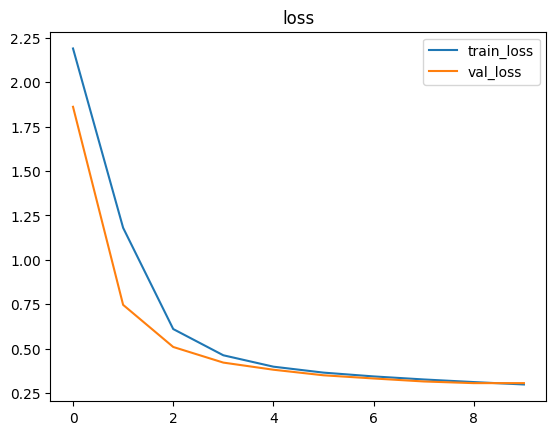

In [22]:
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('loss')
plt.show()

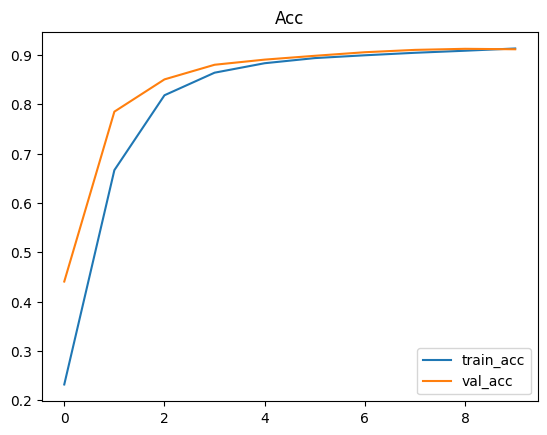

In [23]:
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.title('Acc')
plt.show()

#### Generate file for Kaggle

https://www.kaggle.com/competitions/mnist-sai

In [24]:
class MNISTTestDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.x_data = data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        img = self.x_data[idx]
        img = self.transform(img)
        return img

test_ds = MNISTTestDataset(x_test)
test_loader = torch.utils.data.DataLoader(test_ds, BATCH_SIZE)

In [25]:
# Predict all data
y_pred = []

model.to(device)
model.eval()

with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred)

y_pred = torch.cat(y_pred).argmax(1).cpu().numpy()
y_pred.shape

(10000,)

In [26]:
import pandas as pd

df = pd.DataFrame()
df['Id'] = [str(i) for i in range(len(x_test))]
df['Category'] = y_pred
df.to_csv('result.csv', index=None)
df

,Id,Category
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4
...,...,...
9995,9995,2
9996,9996,3
9997,9997,4
9998,9998,5
